In [ ]:
%matplotlib inline
import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy
from desispec.io import read_spectra, write_spectra
from desispec.spectra import Spectra

import matplotlib.pyplot as plt
from IPython import display
from astropy.table import Table,vstack
from desiutil.log import get_logger, DEBUG
from desidiff.src.group_tiles import *
from desidiff.src.dates_to_process import *
from desidiff.src.coadd import *
from desidiff.src.scores import *
from desidiff.src.TDE_Filter import *
import requests
from timedomain.sp_utils import SkyPortal as sp
import datetime

In [ ]:
# Loop over unprocessed night, doesn't need to be run as we debug
night_arr = getUnprocessedDates()
for a in night_arr:   
    # read in and store in one place all the fibermap information in the spectra files
    date = a

In [ ]:
date=20210603
tile_petal,group_tid,group_tp, group_night =getMatchedTileid(date)

In [ ]:
#Set non-default plot size 
plt.rcParams["figure.figsize"] = (20,6)

#SkyPortal token:
secret_file = "/global/cfs/cdirs/desi/science/td/secrets/desidiff_sp.txt"
with open(secret_file, 'r') as file:
    token = file.read().replace('\n', '')
headers = {'Authorization': f'token {token}'}

filter_name = 'DESIDIFF'

INFO:spectra.py:282:read_spectra: iotime 1.284 sec to read spectra-2-20120-thru20210603.fits at 2021-09-30T10:04:36.093246
INFO:spectra.py:282:read_spectra: iotime 2.369 sec to read spectra-2-1120-thru20210603.fits at 2021-09-30T10:04:39.252629


[39627697571237011]
[-- 'line' --]


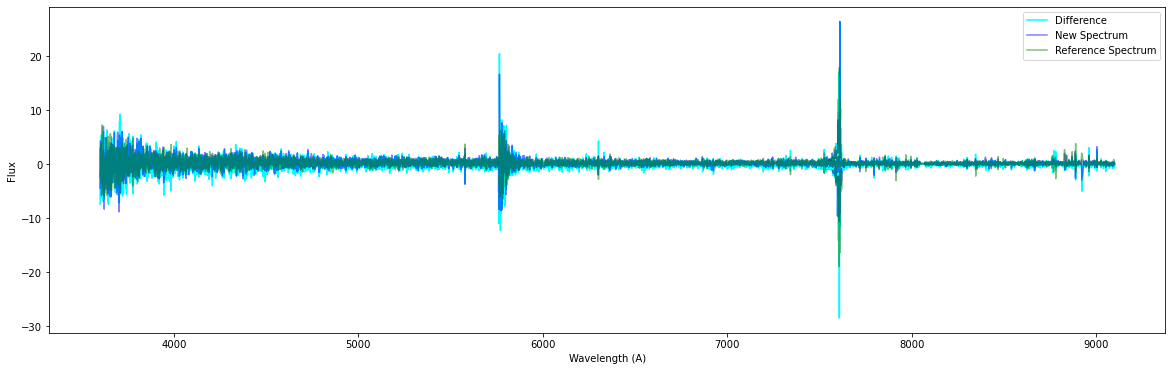

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[39627697571237123]
[-- 'line' --]


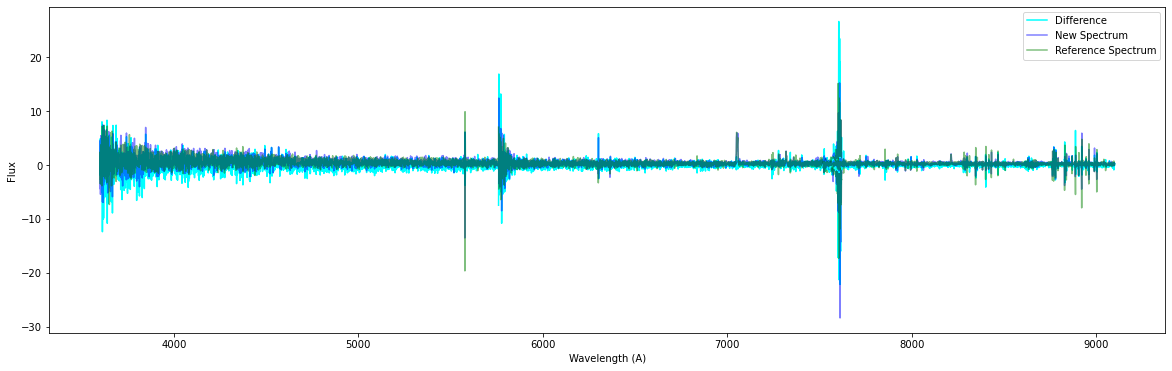

[39627697571237160]
[-- 'line' --]


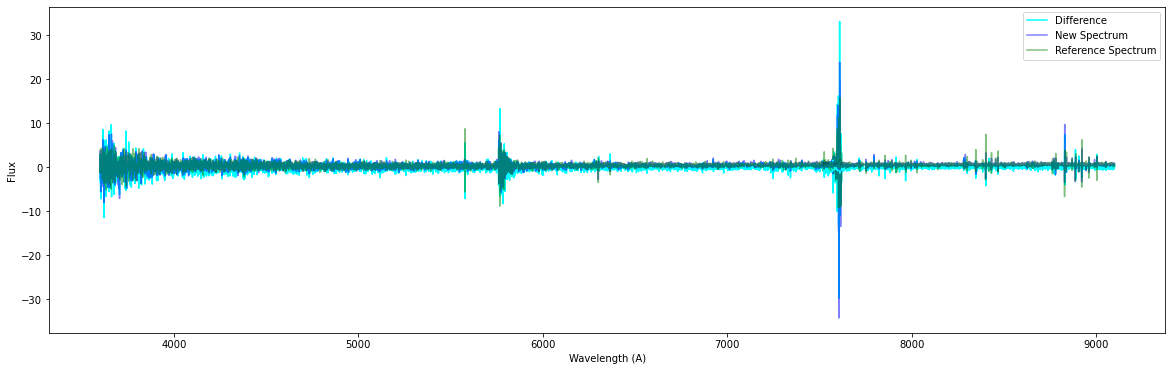

[39627697571237525]
[-- 'line' --]


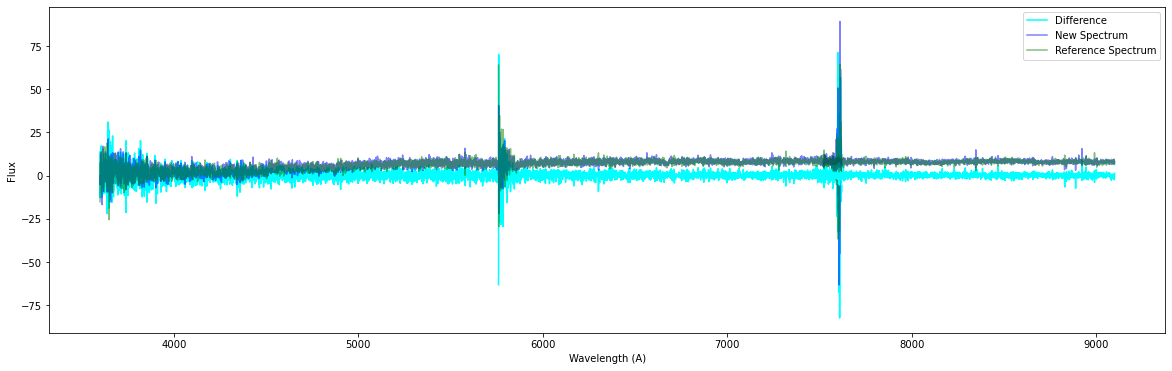

[39627691539828037]
[-- 'line' --]


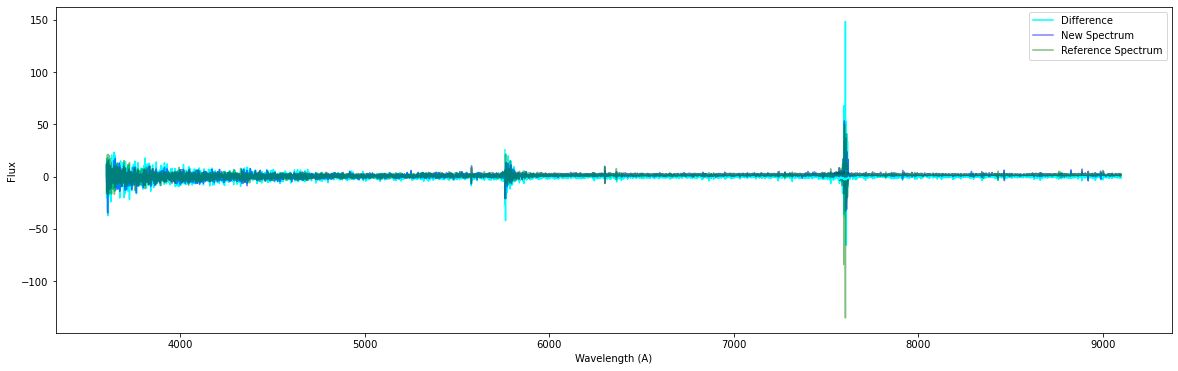

[39627691539828089]
[-- 'line' --]


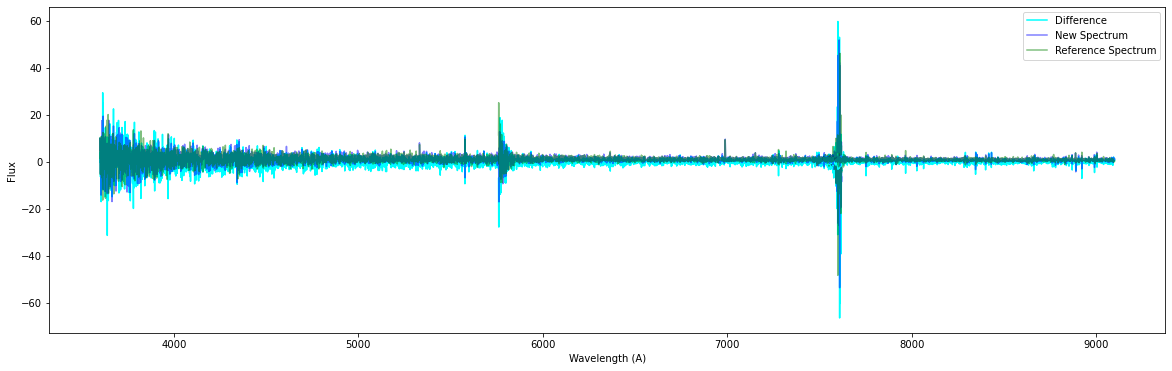

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[39627691539828364]
[-- 'line' --]


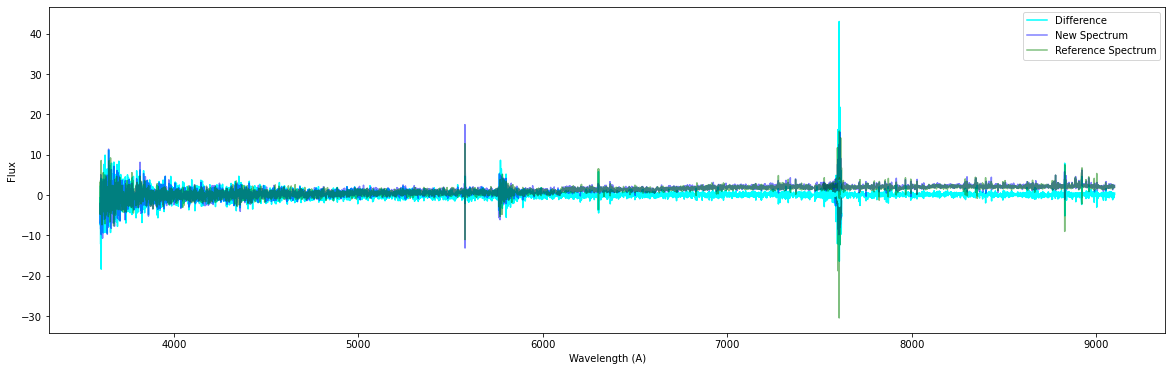

[39627691539828487]
[-- 'line' --]


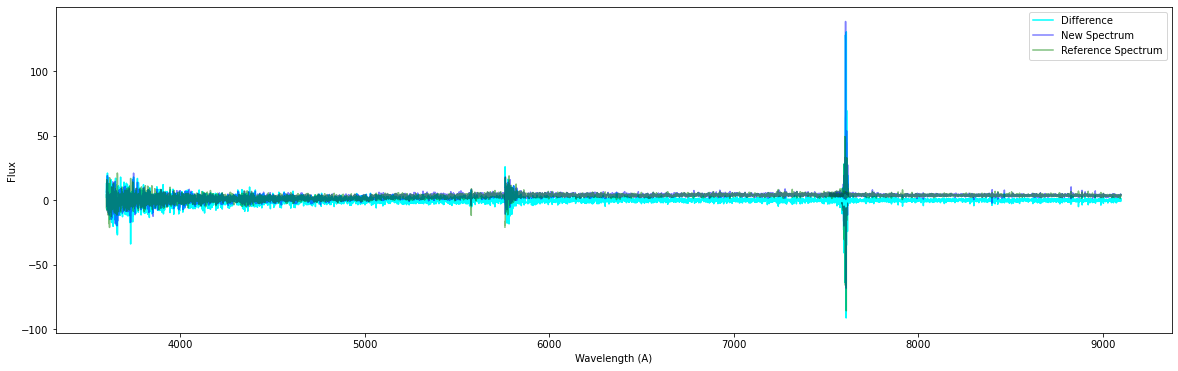

[39627691539828538]
[-- 'line' --]


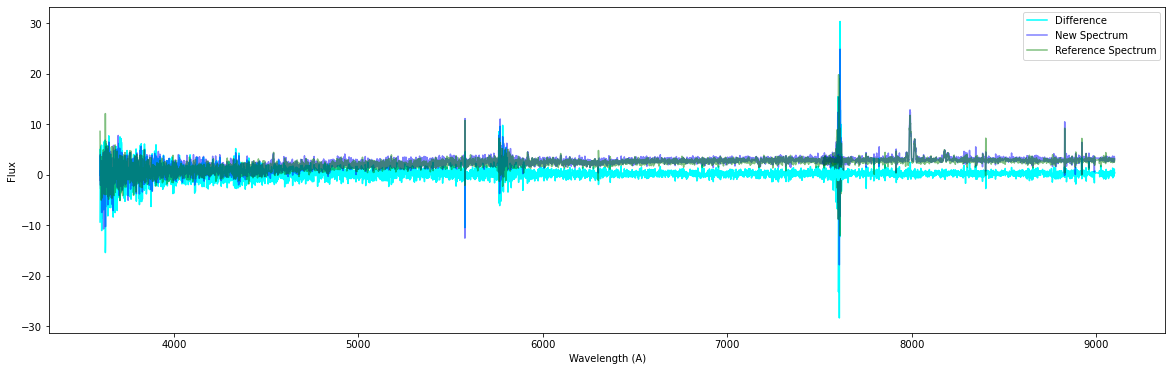

[39627691539828578]
[-- 'line' --]


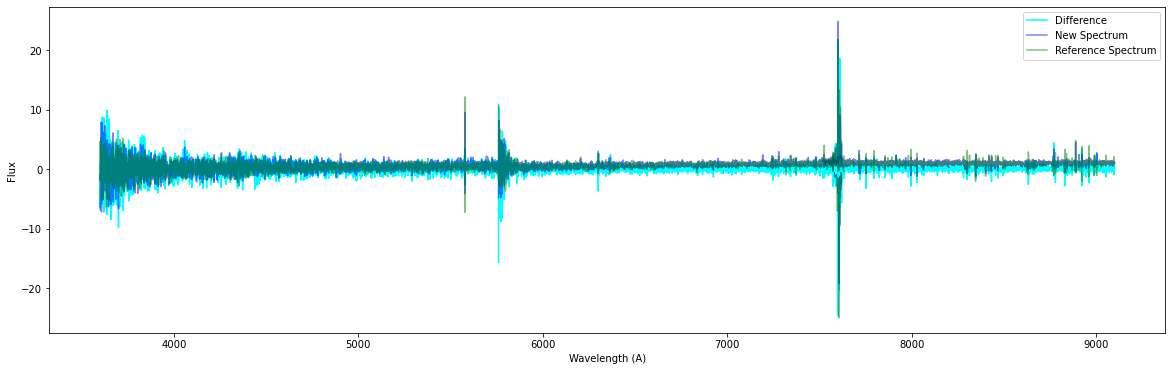

NameError: name 'wefwe' is not defined

In [137]:
# tile_petal contain subsets of tile/petals whose RA/DEC targets are not contained in other tile/petals from that night
for tps in tile_petal:
    # Check to see if this tile/petal has nothing to subtract.  Skip's IO if this is the case
    if hasNothingToProcess(tps,group_tid,group_tp,group_night):
        continue
    
    # cache spectra to minimize IO
    spectra_list=dict()
    zbest_list = []
    target_list=[]
    ra_dec_list = []
    for tp in tps:
        filename =  f"/global/project/projectdirs/desi/spectro/redux/daily/tiles/cumulative/{tp[0]}/{date}/spectra-{tp[1]}-{tp[0]}-thru{date}.fits"
        spectra_list[(tp[0],tp[1])]=read_spectra(filename)
        #To get RA/DEC info for the object
        ra_dec_list.append(Table.read(filename, format='fits',hdu=1, memmap=True)['TARGETID','TARGET_RA', 'TARGET_DEC'])
        zbest = filename.replace('spectra','zbest')
        z = Table.read(zbest, format='fits',hdu=1, memmap=True)['TARGETID','Z','ZERR','ZWARN','SPECTYPE']
        zbest_list.append(z)
    z = vstack(zbest_list)
    ra_dec = vstack(ra_dec_list)
    

    count=0
    # loop over all unique RA/DEC pairs from that night
    for tid, tp, night in zip(group_tid,group_tp,group_night):
        # if this RA/DEC is not in thie tile_petal combination than skip
        if tp[0] not in tps:
            continue
            
        if len(night) == 1:
            continue
            
#         print(tid)

        # Eliminate those with no reference night here
        # Proceed with a subtraction for this object
        
        # The coadds of the new and reference are constructed from all spectra with all targetid's in tid and all
        # tile/petal combinations in tp, which are cached above
        
        # Finds the object in the zbest by matching the targetID.
        #Stores a tuple = (TARGETID, Z, ZERR,ZWARN, SPECTYPE)
        z_data = []
        ra_dec_data = []
        for t in tid:
            tid_ind = list(z['TARGETID']).index(t)
            ra_dec_ind = list(ra_dec['TARGETID']).index(t)
            z_data.append((t, z[tid_ind]['Z'], z[tid_ind]['ZERR'], z[tid_ind]['ZWARN'], z[tid_ind]['SPECTYPE']))
            ra_dec_data.append((t, ra_dec[ra_dec_ind]['TARGET_RA'], ra_dec[ra_dec_ind]['TARGET_DEC']))
            
        newSpectra=[]
        refSpectra=[]
        for tile,plate in tp:
            spec = spectra_list[(tile,plate)]

            idx = numpy.in1d(night, date)
            ref_night = night[~idx]
            
            newSpectra.append(spec.select(nights=date, targets = tid))
            
            """
            There is a variable night that has all the nights associated with this RA/DEC
            derive the ref_night from that
            """
            
            refSpectra.append(spec.select(nights=ref_night, targets = tid))       
         
        newflux, newivar, newwave, newmask = coadd(newSpectra)
        refflux, refivar, refwave, refmask = coadd(refSpectra)

        difflux, difivar, difmask, difwave = dict.fromkeys(["b", "r", "z"]), dict.fromkeys(["b", "r", "z"]), dict.fromkeys(["b", "r", "z"]), dict.fromkeys(["b", "r", "z"])
        
        difflux = {key: newflux[key] - refflux[key]
                       for key in newflux.keys()}
        difivar = {key: newivar[key] + refivar[key]
                       for key in newivar.keys()}
        difmask = {key: newmask[key] + refmask[key]
                       for key in newmask.keys()}
        difwave = dict(newwave)
        
        redshift = z_data[0][1] #it seems each set only has one value
        spectype = z_data[0][-1]
        ## filters         
        # trim red edge 
        if 'z' in difflux.keys():
            w=numpy.where(difwave['z'] < 9100)[0]
            difflux['z']=difflux['z'][w]
            difivar['z']=difivar['z'][w]
            difwave['z']=difwave['z'][w]
            difmask['z']=difmask['z'][w]
            
        # mean-subtracted difference
        difflux_clipmean = clipmean(difflux,difivar,difmask)
        
        # Difference spectrum may have broadband signal
        perband_filter = perband_SN(difflux_clipmean,difivar,difmask)
        
        # fractional increase
        perband_inc = perband_increase(difflux_clipmean,difivar,difmask, refflux,refivar,refmask)
        
        # Difference spectrum may have high-frequency signal
        perres_filter = perconv_SN(difflux_clipmean,difivar,difmask)
        
        #Search for signature lines of TDEs, only interested in Galaxies

        TDE_score = TDE_Check(difwave, difflux, redshift, multifilt = True, spectype = spectype)

#         print(perband_filter, perband_inc, perres_filter)
#         print(any(list(perband_filter.values())), numpy.sum(list(perres_filter.values())) >1)

        #broadband
        bblogic = any(numpy.logical_and(numpy.array(list(perband_filter.values()))>10, numpy.array(list(perband_inc.values()))>0.25))
        linelogic = numpy.sum(list(perres_filter.values()))>4
        TDElogic = any([TDE_score == 2, TDE_score == 3, TDE_score == 4])
        logic = [bblogic,linelogic, TDElogic]
        logic_name = ['Broadband', 'line', 'TDE'] #must be in same order as logic!, use as mask
        logic_name = np.ma.masked_array(logic_name, mask = [not i for i in logic])
        plt.clf()
        if any(logic):
            #Uncomment next line if you want to print only those TargetIds that get plotted
            print(tid)
            print(logic_name)
            for b in difflux.keys():
                w=numpy.where(difmask[b] ==0)[0]
                if b == list(difflux.keys())[-1]:
                    plt.plot(difwave[b][w],difflux[b][w],color='cyan', label = 'Difference')
                    plt.plot(newwave[b][w],newflux[b][w],color='blue',alpha=0.5, label = 'New Spectrum')
                    plt.plot(refwave[b][w],refflux[b][w],color='green',alpha=0.5, label = 'Reference Spectrum')
                    plt.legend()
                else:
                    plt.plot(difwave[b][w],difflux[b][w],color='cyan')
                    plt.plot(newwave[b][w],newflux[b][w],color='blue',alpha=0.5)
                    plt.plot(refwave[b][w],refflux[b][w],color='green',alpha=0.5)

            plt.xlabel('Wavelength (A)')
            plt.ylabel('Flux') 
            plt.show()
            count=count+1
            
            #SkyPortal functionality begins:
            #Combine the wavelengths into one 
            wavelengths = []
            for b in difflux.keys():
                wavelengths += difwave[b].tolist()
            
            flux = []
            #Combine the differenced flux into one 
            for b in difflux.keys():
                flux += difflux[b].tolist()
            
            #Code to make wavelengths monotonic with corresponding changes in flux:
            wavelengths, flux = (list(t) for t in zip(*sorted(zip(wavelengths, flux))))
            
            #SkyPortal's Id for the object
            objID = 'DESI{}'.format(str(tid[0]))

            #Code to check if this object already exists in SkyPortal. If not, create it
            response = requests.get("http://desi2.lbl.gov:5000/api/candidates/{}".format(objID), headers={"Authorization": f"token {token}"})
            if response.status_code == 400:
                obj_data = {
                        "ra": ra_dec_data[0][1], #RA is required when creating a new object.
                        "dec": ra_dec_data[0][2], #Same for DEC
                        "id": objID,
                        "redshift": z_data[0][1],
                        "filter_ids": [sp.filter_id(filter_name)],
                        "passed_at": str(datetime.datetime.utcnow()) #UTC time when the object passed the filter
                        }

                response = requests.post(
                        "http://desi2.lbl.gov:5000/api/candidates",
                        json= obj_data,
                        headers={"Authorization": f"token {token}"})

            #Now, we send the differenced spectrum to SkyPortal
            #First, check if the same spectrum already exists under the object
            response = requests.get("http://desi2.lbl.gov:5000/api/sources/{}/spectra".format(objID),headers={"Authorization": f"token {token}"})
            post = True
            for i in range (len(response.json()['data']['spectra'])):
                if (wavelengths == response.json()['data']['spectra'][i]['wavelengths'] and flux == response.json()['data']['spectra'][i]['fluxes']):
                    post = False
            #Only if the exact same spectrum doesn't already exist, upload it.
            if post:
                #Send difference spectrum to SP:
                diff_spectrum_data = {
                        "obj_id": objID,
                        "wavelengths": wavelengths,
                        "fluxes": flux,
                        "observed_at": str(date)[:4]+'-'+str(date)[4:6]+'-'+str(date)[6:]+' '+'00:00:00.000000', # Date converted into UTC time format
                        "origin": "DESIDIFF", #Only the difference spectrum gets this tag in order to distinguish it on SkyPortal
                        "instrument_id": sp.instrument_id()
                        }
                response = requests.post(
                            '{}/api/spectrum'.format(sp.url),
                            json= diff_spectrum_data,
                            headers={"Authorization": f"token {token}"}) 
                
                #Send new specta to SP:
                for spec in newSpectra:
                    new_wavelengths = []
                    for b in spec.wave.keys():
                        new_wavelengths += spec.wave[b].tolist()
            
                    new_flux = []
                    for b in spec.flux.keys():
                        new_flux += spec.flux[b].tolist()
                    new_flux = [item for sublist in new_flux for item in sublist] #This code is required because the list is a list of lists
            
                    #Code to make wavelengths monotonic with corresponding changes in flux:
                    new_wavelengths, new_flux = (list(t) for t in zip(*sorted(zip(new_wavelengths, new_flux))))
                    
                    new_spectra_data = {
                        "obj_id": objID,
                        "wavelengths":new_wavelengths,
                        "fluxes": new_flux,
                        "observed_at": str(date)[:4]+'-'+str(date)[4:6]+'-'+str(date)[6:]+' '+'00:00:00.000000', # Date converted into UTC time format
                        "instrument_id": sp.instrument_id()
                        }
                    response = requests.post(
                            '{}/api/spectrum'.format(sp.url),
                            json= new_spectra_data,
                            headers={"Authorization": f"token {token}"}) 
                
                #Sending reference spectra to SP
                for spec in refSpectra:
                    ref_wavelengths = []
                    for b in spec.wave.keys():
                        ref_wavelengths += spec.wave[b].tolist()
            
                    ref_flux = []
                    for b in spec.flux.keys():
                        ref_flux += spec.flux[b].tolist()
                    ref_flux = [item for sublist in ref_flux for item in sublist] #This code is required because the list is a list of lists
            
                    #Code to make wavelengths monotonic with corresponding changes in flux:
                    ref_wavelengths, ref_flux = (list(t) for t in zip(*sorted(zip(ref_wavelengths, ref_flux))))
                    
                    ref_spectra_data = {
                        "obj_id": objID,
                        "wavelengths": ref_wavelengths,
                        "fluxes": ref_flux,
                        "observed_at": str(date)[:4]+'-'+str(date)[4:6]+'-'+str(date)[6:]+' '+'00:00:00.000000', # Date converted into UTC time format
                        "instrument_id": sp.instrument_id()
                        }
                    response = requests.post(
                            '{}/api/spectrum'.format(sp.url),
                            json= ref_spectra_data,
                            headers={"Authorization": f"token {token}"}) 
                    
        if count==10:
            wefwe